# 3.6.1

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
print(f"Train data is of shape:{train_data.shape}\nTest data is of shape:{test_data.shape}")
print(f"Targets are median values of homes in thousands of dollars:\n{train_targets[0:10]} * 1000$\n")

# First we normalize the data.
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std
print(f"Train data mean:\n{mean}\nTrain data standard deviation:\n{std}")
print(f"Normalized test data mean:\n{test_data.mean(axis=0)}\n"
      f"Normalized test data standard deviation:\n{test_data.std(axis=0)}")

Using TensorFlow backend.


Train data is of shape:(404, 13)
Test data is of shape:(102, 13)
Targets are median values of homes in thousands of dollars:
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4] * 1000$

Train data mean:
[3.74511057e+00 1.14801980e+01 1.11044307e+01 6.18811881e-02
 5.57355941e-01 6.26708168e+00 6.90106436e+01 3.74027079e+00
 9.44059406e+00 4.05898515e+02 1.84759901e+01 3.54783168e+02
 1.27408168e+01]
Train data standard deviation:
[9.22929073e+00 2.37382770e+01 6.80287253e+00 2.40939633e-01
 1.17147847e-01 7.08908627e-01 2.79060634e+01 2.02770050e+00
 8.68758849e+00 1.66168506e+02 2.19765689e+00 9.39946015e+01
 7.24556085e+00]
Normalized test data mean:
[-0.0707286  -0.02435885  0.02358875  0.1500709  -0.11267862  0.12282991
 -0.07746073  0.13399985  0.0621344   0.06981759 -0.04617659  0.09979472
 -0.06008184]
Normalized test data standard deviation:
[0.57931694 0.90431666 1.03622933 1.23419987 0.93449418 0.94374857
 1.03534182 1.16796212 1.00476841 1.06228778 0.91771633 0.83780808
 0.9

We can see that even though the mean and standard deviation is not a perfect fit for test data it gets it on the same order of magnitude at least.

Next we define a function to build the model.

In [28]:
# Using a 2x64 neuron network.
from keras import models
from keras import layers
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))     # No activation makes a linear layer.
    model.compile(optimizer='rmsprop',
                  loss='mse',
                  metrics=['mae'])
    return model

Since the dataset is so small we use K-fold split. Essentialy we partition the data into K partitions train K identical models and train on K-1 partitions and evaluate on the last one. The final validation score is the average of all the scores. 

In [29]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k # // does floor division. Extra samples from the end are discarded.
num_epochs = 80
all_mae_histories = []

# Perform K-fold split of the data.
for i in range(k):
    print(f"Processing fold {i} .")
    # Take i-th partiton as validation data.
    val_data    = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    # Take the rest as train data.
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                           axis=0)
    # Build the model and fit it.
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs,
                        batch_size=16,
                        verbose=0)
    # Save validation results.
    mae_history = history.history["val_mean_absolute_error"]
    all_mae_histories.append(mae_history)

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
# Print final mean absolute error.
print(f"Average mae : {average_mae_history[-1]:.2f} * 1000 $")

Processing fold 0 .
Processing fold 1 .
Processing fold 2 .
Processing fold 3 .
Average mae : 2.37 * 1000 $


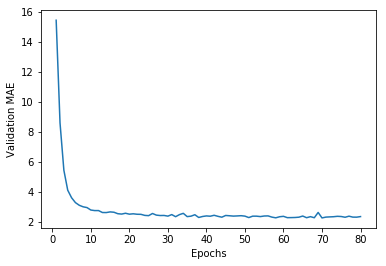

In [23]:
# Normal plotting.
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

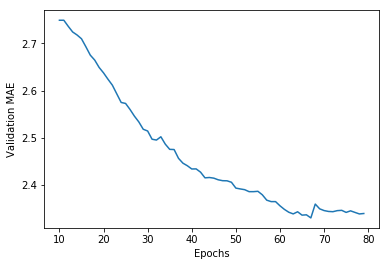

In [22]:
# Plot a smoth graph: apply a exponential moving average to the data.
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Ommit first 10 Epochs.
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(10, len(smooth_mae_history)+ 10), smooth_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

# Train final model

In [30]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=80,
          batch_size=8,
          verbose=0)
(test_mse_score, test_mae_score) = model.evaluate(test_data,test_targets)
print(f"Model mae score for test data: {test_mae_score:.2f} * 1000$")

102/102 [==============================] - 0s 4ms/step
Model mae score for test data: 2.44 * 1000$


## Tuning log
- STEP 1: 2 X 64 Dense, 500 epochs, mae: 2.69, overfitting after 80 epochs.
- STEP 2: 2 X 64 Dense, 80 epochs,  mae: 2.56
- STEP 3: 2 X 32 Dense, 80 epochs, batch size 1, mae: 2.52
- STEP 4: 2 X 32 Dense, 80 epochs, batch size 8,  mae: 2.33
- STEP 4: 2 X 32 Dense, 80 epochs, batch size 16,  mae: 2.48
- STEP 4: 2 X 128 Dense, 80 epochs, batch size 16,  mae: 2.35
